In [1]:
import numpy as np
import pandas as pd
import discretize
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from scipy.constants import mu_0

import time

from simpeg.electromagnetics import time_domain as tdem
from simpeg import maps, utils

In [2]:
Solver = utils.solver_utils.get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

In [3]:
station_locs = pd.read_csv("StationLocations_NAD83.csv", skiprows=5)
station_locs.head()

,Station,Easting,Northing,Comp,Elev_ASTER
0,100,420425,5589298,TX,773
1,200,420425,5589298,TX,773
2,300,420505,5589301,TX,774
3,301,420489,5589300,TX,773
4,302,420490,5589300,TX,773


In [4]:
comps = np.unique(station_locs["Comp"])
comps

array(['Ex1', 'Ex2', 'Ey1', 'Ey2', 'Hx1', 'Hx2', 'Hy1', 'Hy2', 'TX',
       'ZEN'], dtype=object)

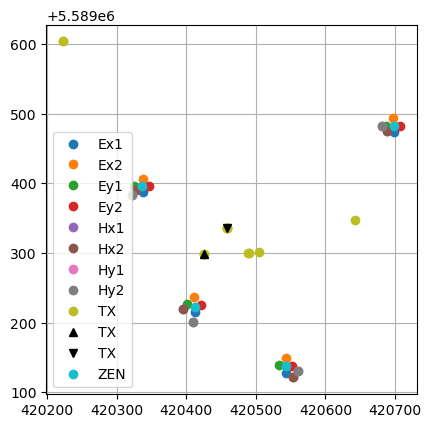

In [5]:
fig, ax = plt.subplots(1, 1) 

for i, c in enumerate(comps): 
    inds = station_locs["Comp"] == c
    ax.plot(
        station_locs[inds]["Easting"], station_locs[inds]["Northing"], f"C{i}o",
        label=c
    )
    if c == "TX": 
        tx100 = station_locs["Station"] == 100
        ax.plot(
            station_locs[tx100]["Easting"], station_locs[tx100]["Northing"], f"k^",
            label=c
        )
        tx400 = station_locs["Station"] == 400
        ax.plot(
            station_locs[tx400]["Easting"], station_locs[tx400]["Northing"], f"kv",
            label=c
        )
    
    ax.legend()

ax.grid()
ax.set_aspect(1)

In [6]:
tx100 = station_locs[station_locs["Station"] == 100]
tx400 = station_locs[station_locs["Station"] == 400]

In [7]:
np.sqrt((tx400["Easting"].values - tx100["Easting"].values)**2 + (tx400["Northing"].values - tx100["Northing"].values)**2)

array([50.99019514])

In [8]:
# add injector well to data_frame. It is 20m from TX100 in same line as TX400
dx = (tx400["Easting"].values - tx100["Easting"].values)
dy = (tx400["Northing"].values - tx100["Northing"].values)

theta = np.atan(dy/dx)

distance = 20
well_x = np.round(tx100["Easting"].values + distance * np.cos(theta))
well_y = np.round(tx100["Northing"].values + distance * np.sin(theta))



In [9]:
station_locs.head()

,Station,Easting,Northing,Comp,Elev_ASTER
0,100,420425,5589298,TX,773
1,200,420425,5589298,TX,773
2,300,420505,5589301,TX,774
3,301,420489,5589300,TX,773
4,302,420490,5589300,TX,773


In [10]:
tx100["Elev_ASTER"].values[0] 

np.int64(773)

In [11]:
stations = pd.concat([
    station_locs,
    pd.DataFrame(
        {
            "Station": 1000,
            "Easting": well_x,
            "Northing": well_y, 
            "Comp":"INJ",
            "Elev_ASTER": tx100["Elev_ASTER"].values
        }
    ),
], ignore_index=True)

In [12]:
stations.head

<bound method NDFrame.head of     Station   Easting   Northing Comp  Elev_ASTER
0       100  420425.0  5589298.0   TX         773
1       200  420425.0  5589298.0   TX         773
2       300  420505.0  5589301.0   TX         774
3       301  420489.0  5589300.0   TX         773
4       302  420490.0  5589300.0   TX         773
5       400  420459.0  5589336.0   TX         774
6       401  420459.0  5589336.0   TX         774
7       402  420223.0  5589604.0   TX         772
8       500  420459.0  5589336.0   TX         774
9       501  420643.0  5589348.0   TX         770
10      502  420223.0  5589604.0   TX         772
11        1  420698.0  5589474.0  Ex1         774
12        1  420687.0  5589483.0  Ey1         775
13        1  420688.0  5589475.0  Hx1         775
14        1  420681.0  5589482.0  Hy1         776
15        1  420697.0  5589494.0  Ex2         775
16        1  420707.0  5589482.0  Ey2         773
17        1  420688.0  5589475.0  Hx2         775
18        1  420681.

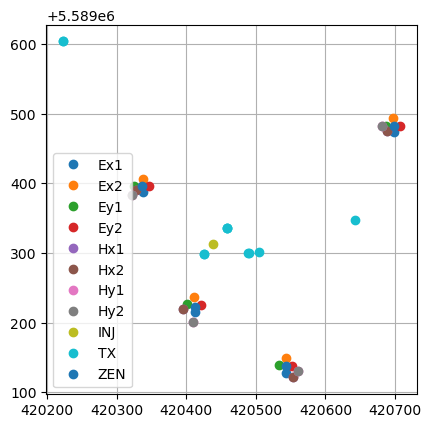

In [13]:
fig, ax = plt.subplots(1, 1) 

for i, c in enumerate(np.unique(stations["Comp"])): 
    inds = stations["Comp"] == c
    ax.plot(
        stations[inds]["Easting"], stations[inds]["Northing"], f"C{i}o",
        label=c
    )
    
    ax.legend()

ax.grid()
ax.set_aspect(1)

In [14]:
origin_x = stations[stations["Comp"] == "INJ"]["Easting"]
origin_y = stations[stations["Comp"] == "INJ"]["Northing"]

In [15]:
stations["local_x"] = stations["Easting"] - origin_x.values
stations["local_y"] = stations["Northing"] - origin_y.values

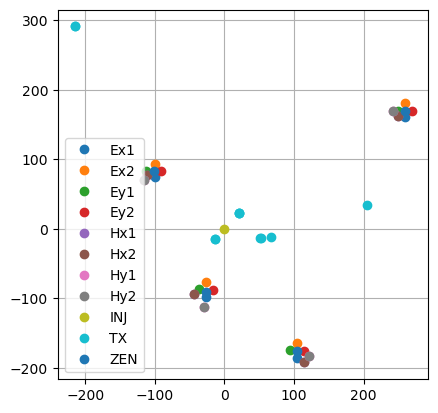

In [16]:
fig, ax = plt.subplots(1, 1) 

for i, c in enumerate(np.unique(stations["Comp"])): 
    inds = stations["Comp"] == c
    ax.plot(
        stations[inds]["local_x"], stations[inds]["local_y"], f"C{i}o",
        label=c
    )
    
    ax.legend()

ax.grid()
ax.set_aspect(1)

apply rotation for given source (make source a straight line) 

In [17]:
# theta = -45*np.pi/180
# stations["rotated_x"] = stations["local_x"] * np.cos(theta) + stations["local_y"] * np.sin(theta)
# stations["rotated_y"] = -stations["local_x"] * np.sin(theta) + stations["local_y"] * np.cos(theta)

In [18]:
# fig, ax = plt.subplots(1, 1) 

# for i, c in enumerate(np.unique(stations["Comp"])): 
#     inds = stations["Comp"] == c
#     ax.plot(
#         stations[inds]["rotated_x"], stations[inds]["rotated_y"], f"C{i}o",
#         label=c
#     )
    
#     ax.legend()

# ax.grid()
# ax.set_aspect(1)

wellbores are: 
- TX 300 : surface casing to ~30m
- TX 100 : surface casing to ~60m 
- TX 400 : cased to 350m
- INJ : cased to ~350? 

In [19]:
wellbores = stations[(
    stations["Station"].isin([100, 300, 400]) | (stations["Comp"] == "INJ")
)]

In [20]:
wellbores

,Station,Easting,Northing,Comp,Elev_ASTER,local_x,local_y
0,100,420425.0,5589298.0,TX,773,-13.0,-15.0
2,300,420505.0,5589301.0,TX,774,67.0,-12.0
5,400,420459.0,5589336.0,TX,774,21.0,23.0
47,1000,420438.0,5589313.0,INJ,773,0.0,0.0


In [21]:
wellbores.loc[:, "Length"] = [30, 60, 350, 350]
wellbores

/tmp/ipykernel_3462152/2786228961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wellbores.loc[:, "Length"] = [30, 60, 350, 350]


,Station,Easting,Northing,Comp,Elev_ASTER,local_x,local_y,Length
0,100,420425.0,5589298.0,TX,773,-13.0,-15.0,30
2,300,420505.0,5589301.0,TX,774,67.0,-12.0,60
5,400,420459.0,5589336.0,TX,774,21.0,23.0,350
47,1000,420438.0,5589313.0,INJ,773,0.0,0.0,350


design an OcTree mesh, centerd on the Injection well that includes each of the wellbores. 

In [22]:
stationsE = pd.concat([stations[stations["Comp"] == c] for c in ["Ex1", "Ex2", "Ey1", "Ey2"]])

In [23]:
stations_x = np.array([stationsE[stationsE["Station"]==i]["local_x"].mean() for i in np.arange(1, 5)] )
stations_x

array([ 259.25,  -26.75,  104.75, -101.  ])

In [24]:
stations_y = np.array([stationsE[stationsE["Station"]==i]["local_y"].mean() for i in np.arange(1, 5)] )
stations_y

array([ 170.25,  -87.5 , -174.5 ,   83.25])

In [25]:
transmitters = stations[stations["Comp"] == "TX"]
transmitters = pd.concat([
    transmitters[transmitters["Station"] == i] for i in [300, 301, 400, 401]
])

In [26]:
transmitters

,Station,Easting,Northing,Comp,Elev_ASTER,local_x,local_y
2,300,420505.0,5589301.0,TX,774,67.0,-12.0
3,301,420489.0,5589300.0,TX,773,51.0,-13.0
5,400,420459.0,5589336.0,TX,774,21.0,23.0
6,401,420459.0,5589336.0,TX,774,21.0,23.0


In [27]:
rx_locs = np.vstack([
    stations_x, stations_y, np.zeros_like(stations_x)
]).T

In [28]:
cs = 0.25 
extent = 4000 

n_cells = 2 ** np.ceil(np.log2(extent/cs))
h = cs * np.ones(int(n_cells))
mesh = discretize.TreeMesh(
    [h, h, h], origin="CCC", diagonal_balance=True
)

# # refine survey area
# mesh.refine_bounding_box(
#     np.vstack([
#         stations["local_x"], 
#         stations["local_y"],
#         np.zeros(stations.shape[0])
#     ]).T, level=7,
#     diagonal_balance=True, finalize=False
# )

# refine around receivers 
mesh.refine_points(
    rx_locs, 
    level=-2,
    padding_cells_by_level=[4, 2, 2], 
    diagonal_balance=True,
    finalize=False
)

# refine transmitter line
st300 = transmitters[transmitters["Station"] == 300]
st301 = transmitters[transmitters["Station"] == 301]
st400 = stations[(stations["Station"] == 400) | (stations["Station"] == 401) | (stations["Station"] == 402)]

mesh.refine_line(
    np.vstack([
        np.r_[st300["local_x"], st301["local_x"]],
        np.r_[st300["local_y"], st301["local_y"]],
        np.r_[0, 0]
    ]).T, 
    levels=[-2], 
    finalize=False, 
    diagonal_balance=True
)

mesh.refine_line(
    np.vstack([
        st400["local_x"], st400["local_y"], np.r_[-wellbores[wellbores["Station"] == 400]["Length"], 0, 0],
    ]).T, 
    levels=[-2, -2], 
    finalize=False, 
    diagonal_balance=True
)



# refine around wellbores
# tmp = {}
for index, row in wellbores.iterrows():
    
    z = np.linspace(-row["Length"], 0, int(row["Length"]/cs))
    x = row["local_x"] * np.ones_like(z)
    y = row["local_y"] * np.ones_like(z)

    mesh.refine_points(
        np.vstack([x, y, z]).T, 
        level=-1,
        padding_cells_by_level=[4, 2], 
        diagonal_balance=True,
        finalize=False
    )


mesh.finalize()
    

In [29]:
mesh

OcTreeMesh,0.00% filled
Level,Number of cells
3,448
4,414
5,630
6,952
7,1770
8,2822
9,5662
10,11168
11,22120


(-500.0, 500.0)

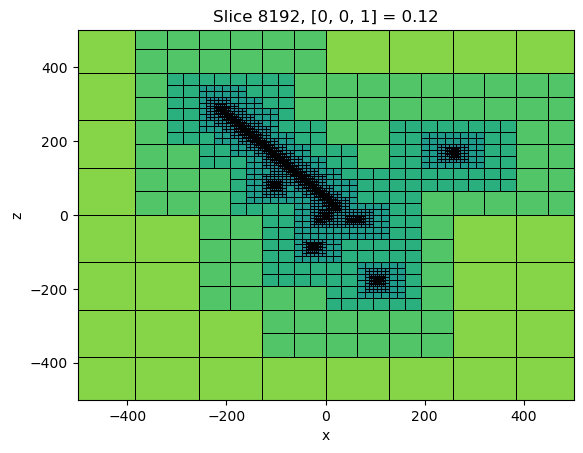

In [30]:
fig, ax = plt.subplots(1, 1)
mesh.plot_slice(
    np.log10(mesh.cell_volumes),
    normal="Z",
    grid_opts={"color":"k", "lw":0.5},
    ax=ax
)
ax.set_xlim(np.r_[-1, 1]*500)
ax.set_ylim(np.r_[-1, 1]*500)

# define physical properties

In [31]:
# approximate values for casing 
sigma_steel = 5e6
casing_b = 5e-2
casing_a = 4e-2
cross_sectional_area = np.pi * (casing_b**2 - casing_a**2)



In [32]:
sigma_air = 1e-4
sigma_back = 1e-1  # 10 Ohm m 

In [34]:
casing_n_cells = 8
casing_approx_width = mesh.h[0].min() * casing_n_cells
casing_approx_width

sigma_casing_approx = sigma_steel * cross_sectional_area / casing_approx_width**2
sigma_casing_approx

np.float64(3534.291735288519)

In [35]:
mur_casing_approx = 20

In [36]:
models = {}

# create the models 
halfspace = np.ones(mesh.n_cells) * sigma_back
halfspace[mesh.cell_centers[:, 2] > 0] = sigma_air
mur_halfspace = np.ones(mesh.n_cells)

models["halfspace"] = {
    "sigma": halfspace,
    "mur": mur_halfspace,
}

# conductive casing 
casing = halfspace.copy()
mur_casing = mur_halfspace.copy()

for index, row in wellbores.iterrows():
    inds_casing = (
        (mesh.cell_centers[:, 0] < row["local_x"] + casing_approx_width/2) & 
        (mesh.cell_centers[:, 0] > row["local_x"] - casing_approx_width/2) & 
        (mesh.cell_centers[:, 1] < row["local_y"] + casing_approx_width/2) & 
        (mesh.cell_centers[:, 1] > row["local_y"] - casing_approx_width/2) &
        (mesh.cell_centers[:, 2] < 0) & 
        (mesh.cell_centers[:, 2] > -row["Length"])
    )
    casing[inds_casing] = sigma_casing_approx
    mur_casing[inds_casing] = mur_casing_approx

models["conductive_casing"] = {
    "sigma": casing, 
    "mur": mur_halfspace, 
}

models["permeble_casing"] = {
    "sigma": casing, 
    "mur": mur_casing
}

(-5.0, 5.0)

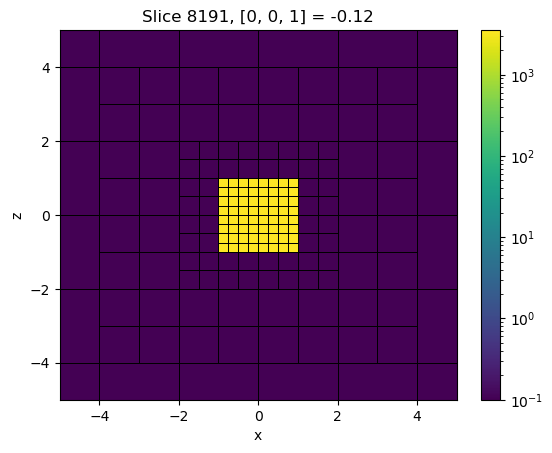

In [39]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(mesh.plot_slice(
    models["conductive_casing"]["sigma"],
    normal="Z",
    ind=8191,
    # ind=16383,
    grid_opts={"color":"k", "lw":0.5},
    pcolor_opts={"norm":LogNorm()},
    ax=ax
)[0], ax=ax) 
             
ax.set_xlim(np.r_[-1, 1]*5)
ax.set_ylim(np.r_[-1, 1]*5)

In [40]:
models.keys()

dict_keys(['halfspace', 'conductive_casing', 'permeble_casing'])

In [41]:
time_steps = [
    (1e-6, 20),
    (3e-6, 20),
    (1e-5, 20), 
    (3e-5, 20), 
    (1e-4, 20), 
    (3e-4, 20),
    (1e-3, 20), 
    (3e-3, 20),
    (1e-2, 20), 
    (3e-2, 25),
    # (1e-1, 6), 
]

In [42]:
np.sum(discretize.utils.unpack_widths(time_steps))

np.float64(1.0388800000000002)

In [43]:
rx_times = np.logspace(-5, 0, 50)

In [44]:
rx_locs = np.vstack([stations_x, stations_y, np.zeros_like(stations_x)]).T
rx_list = [
    tdem.receivers.PointElectricField(
        locations=rx_locs, 
        orientation="x",
        times=rx_times
    ),
    tdem.receivers.PointElectricField(
        locations=rx_locs, 
        orientation="y",
        times=rx_times
    )
]

In [45]:
st300 = stations[(stations["Station"] == 300) | (stations["Station"] == 301)]

In [46]:
st400 = stations[(stations["Station"] == 400) | (stations["Station"] == 401) | (stations["Station"] == 402)]

In [47]:
src_list = [
    tdem.sources.LineCurrent(
        receiver_list = rx_list, 
        location = np.vstack([
            st300["local_x"], st300["local_y"], np.zeros(st300.shape[0]),
        ]).T
    ),
    tdem.sources.LineCurrent(
        receiver_list = rx_list, 
        location = np.vstack([
            st400["local_x"], st400["local_y"], np.r_[-wellbores[wellbores["Station"] == 400]["Length"], 0, 0],
        ]).T
    ),
]

In [48]:
survey = tdem.Survey(src_list)

In [49]:
sim = tdem.Simulation3DElectricField(
    mesh=mesh, 
    survey=survey, 
    solver=Solver, 
    solver_opts={"is_symmetric":True, "is_positive_definite":True},
    time_steps=time_steps,
    # verbose=True,
    sigmaMap=maps.IdentityMap(mesh), 
)

In [50]:
directory = "/t40array/lheagy/cami-simulations-3d"

In [ ]:
fields_dict = {}
dpred_dict = {}

for key in models.keys(): 
    print(f"Starting  {key}")
    t0 = time.time()
    sim.mu = mu_0 * models[key]["mur"]
    fields = sim.fields(models[key]["sigma"])
    np.save(f"{directory}/fields_{key}.npy", fields[:, "e"])
    fields_dict[key] = fields
    
    dpred = sim.make_synthetic_data(models[key]["sigma"], f=fields_dict[key])
    np.save(f"{directory}/dpred_{key}.npy", dpred.dobs)
    dpred_dict[key] = dpred
    print(f" ... done. {time.time()-t0:1.2e}s")

Starting  halfspace


/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/simpeg/electromagnetics/utils/current_utils.py:144: UserWarning: Warning! Line path crosses a cell level change.
  return _poly_line_source_tree(mesh, locs)


 ... done. 5.34e+02s
Starting  conductive_casing


In [ ]:
dpred_dict[key]

In [ ]:
rx_locs

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True)
src = src_list[0]
rx_plot = 1

for i, key in enumerate(models.keys()):
    for j, rx in enumerate(src.receiver_list): 
        ax[j].loglog(
            rx_times*1e3, 
            np.abs(dpred_dict[key][src, rx]).reshape(len(rx_times), len(rx_locs))[:, rx_plot], 
            label=key, color=f"C{i}", ls="-"
        )

ax[0].legend()
ax[1].set_xlabel("time (ms)")
ax[1].set_xlim(1e-1, 1e3)
for a in ax:
    a.grid()

In [ ]:
# plot the fields: e.g. Ex component and Ey component at the surface for each scenario 